In [165]:
# Data Processing
import pandas as pd
import numpy as np
import os
import joblib

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.metrics import classification_report
from sklearn import tree
from sklearn.neural_network import MLPClassifier


In [166]:
data_dir = '/Users/rooskraaijveld/Desktop/innovaid_hackathon_anima/csv_variables_2'

In [167]:
selected_columns = ['switches_positive', 'switches_negative', 'switches_neutral', 
                    'duration_positive', 'duration_negative', 'duration_neutral',
                   'velocity_positive', 'velocity_negative', 'velocity_neutral', 
                    'distance_positive','distance_negative','distance_neutral']

In [168]:
# Get features from each csv file
features = []
labels = []

binary = True

for file in os.listdir(data_dir):
    if file.endswith(".csv"):
        file_path = os.path.join(data_dir, file)
        df = pd.read_csv(file_path)
        selected_features = df[selected_columns]
        features.append(selected_features)
        
        label = df['BDI_class'].values[0]
        if binary is True:
            if label == 0 or label == 1: # Split between minor and major risk 
                final_label = 0
            else:
                final_label = 1
        else:
            final_label = label
        labels.append(final_label) 

print("Number of subjects", len(labels))

Number of subjects 3090


In [171]:
X = pd.concat(features, axis=0, ignore_index=True)
y = pd.Series(labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)


In [172]:
print("Number in train set: ", len(X_train))
print("Number in train set: ", len(X_test))

Number in train set:  2781
Number in train set:  309


Accuracy: 0.59547
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.44      0.49       139
           1       0.61      0.72      0.66       170

    accuracy                           0.60       309
   macro avg       0.59      0.58      0.58       309
weighted avg       0.59      0.60      0.59       309



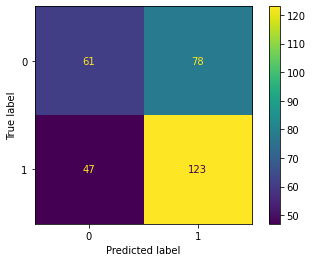

In [173]:
rf_classifier = RandomForestClassifier(criterion='gini')#n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.5f}")

print("Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot();



In [174]:
# Find best parameters for Random Forest

param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

rf = RandomForestClassifier()
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

rand_search.fit(X_train, y_train)

best_rf = rand_search.best_estimator_
print('Best hyperparameters:',  rand_search.best_params_)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fa6080a3be0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fa60a996340>})

Accuracy: 0.58900
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.24      0.34       139
           1       0.58      0.88      0.70       170

    accuracy                           0.59       309
   macro avg       0.60      0.56      0.52       309
weighted avg       0.60      0.59      0.54       309



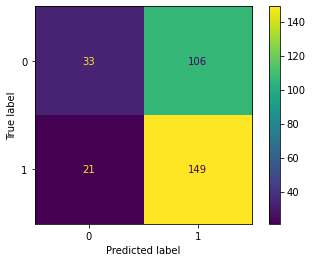

In [176]:
# Run everything again but with the best model
y_pred = best_rf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.5f}")

print("Classification Report:")
print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

# save
save = False
if save:
    joblib.dump(best_rf, "/Users/rooskraaijveld/Desktop/innovaid_hackathon_anima/my_best_random_forest_"+"{:.2f}".format(accuracy)+".joblib")


In [177]:
# Analyse which features are the most important

feature_importances = best_rf.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df)


              Feature  Importance
1   switches_negative    0.146484
10  distance_negative    0.128638
9   distance_positive    0.115157
6   velocity_positive    0.112270
7   velocity_negative    0.110998
11   distance_neutral    0.100219
0   switches_positive    0.095679
2    switches_neutral    0.086843
8    velocity_neutral    0.086241
3   duration_positive    0.006663
4   duration_negative    0.005541
5    duration_neutral    0.005268

Total Importance: 1.0000000000000002


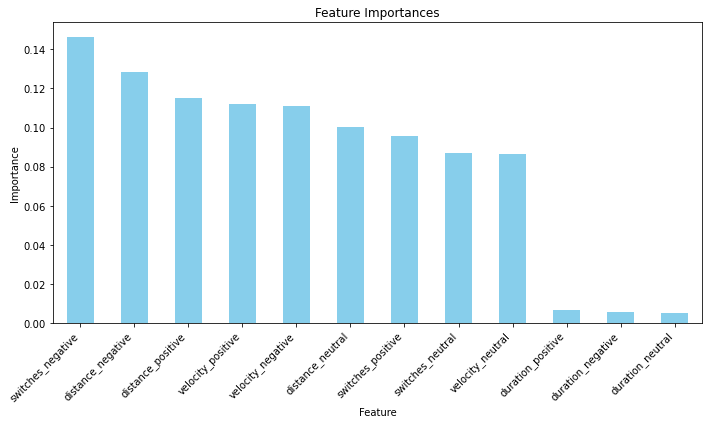

In [179]:
# Plot the feature importances
fig, ax = plt.subplots(figsize=(10, 6))
feature_importance_df.plot(kind='bar', x='Feature', y='Importance', ax=ax, color='skyblue', legend=False)
ax.set_title("Feature Importances")
ax.set_ylabel("Importance")
ax.set_xlabel("Feature")
ax.set_xticklabels(feature_importance_df['Feature'], rotation=45, ha='right')  # Rotate x-axis labels for better readability
fig.tight_layout()


plt.savefig('/Users/rooskraaijveld/Desktop/innovaid_hackathon_anima/feature_importances_plot.png')

plt.show()

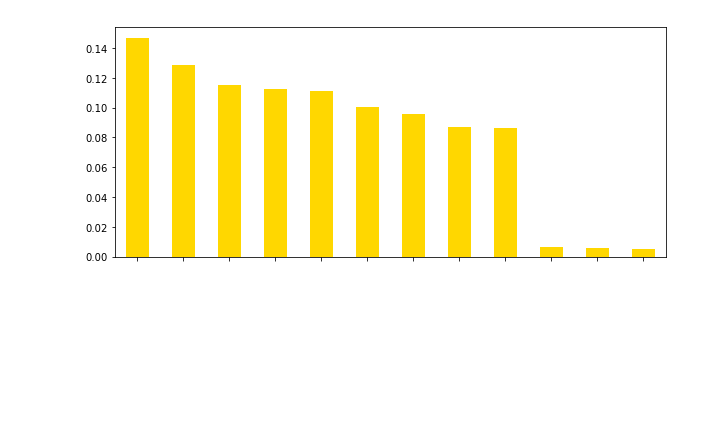

In [186]:
# Plot the feature importances with yellow bars, white text, and increased font size
fig, ax = plt.subplots(figsize=(10, 6), facecolor='white')
feature_importance_df.plot(kind='bar', x='Feature', y='Importance', ax=ax, color='gold', legend=False)
ax.set_title("Importance of Eye Movement Features in Detecting Depression", color='white', fontsize=20)
ax.set_ylabel("Importance", color='white', fontsize=20)
ax.set_xlabel("Feature", color='white', fontsize=20)
ax.set_xticklabels(feature_importance_df['Feature'], rotation=45, ha='right', color='white', fontsize=18)  # Rotate x-axis labels for better readability
fig.tight_layout()

# Save the figure
plt.savefig('/Users/rooskraaijveld/Desktop/innovaid_hackathon_anima/feature_importances_plot2.png', bbox_inches='tight', transparent=True)

plt.show()